<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разбиение-на-выборки" data-toc-modified-id="Разбиение-на-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разбиение на выборки</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3.5"><span class="toc-item-num">3.3.5&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3.3.6"><span class="toc-item-num">3.3.6&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#Лучшая-модель" data-toc-modified-id="Лучшая-модель-3.3.7"><span class="toc-item-num">3.3.7&nbsp;&nbsp;</span>Лучшая модель</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.index.is_monotonic

True

In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Вывод**

Датасет содержит 26496 строк - данные о количестве заказов в период 01.03.2018 - 31.08.2018. Пропусков нет. Индекс упорядочен. Стиль заголовков соблюден.

Интервал временного ряда исходных данных - 10 минут. Ресемплировала данные по одному часу.

## Анализ

In [8]:
def plots(date1, date2, suptitle):

  fig, axes = plt.subplots(1, 3, figsize=(18, 4))
  decomposed.trend[date1:date2].plot(title = 'Trend', ax=axes[0]);
  decomposed.seasonal[date1:date2].plot(title = 'Seasonality', ax=axes[1]); 
  decomposed.resid[date1:date2].plot(title = 'Residuals', ax=axes[2]); 

  fig.suptitle(suptitle)

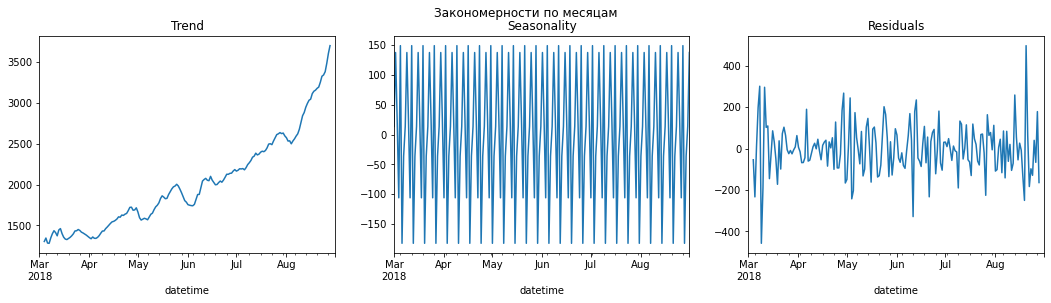

In [9]:
month_data = data.resample('1D').sum() 
decomposed = seasonal_decompose(month_data)
plots(month_data.index.min(), month_data.index.max(), 'Закономерности по месяцам')

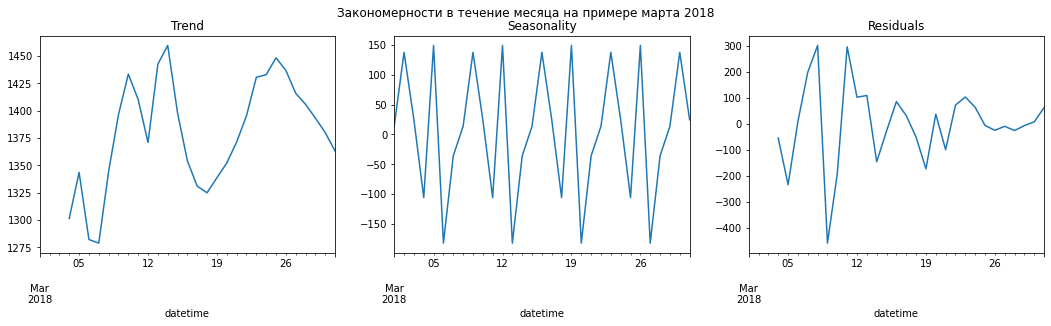

In [10]:
plots('2018-03', '2018-03', 'Закономерности в течение месяца на примере марта 2018')

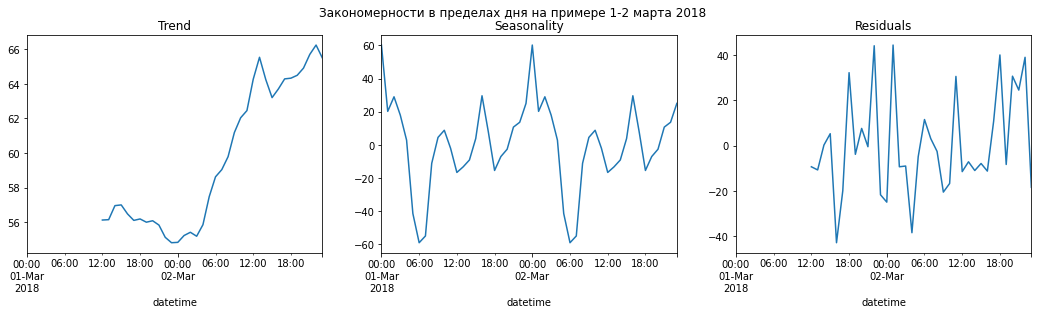

In [11]:
decomposed = seasonal_decompose(data)
plots('2018-03-01', '2018-03-02', 'Закономерности в пределах дня на примере 1-2 марта 2018')

**Вывод**

В тренде по месяцам видно, что спрос на такси неуклонно растет.

В сезонности по месяцам видно еженедельную сезонность, которую удобнее рассмотреть на графике за один месяц.
На примере марта 2018 самый высокий спрос на такси по понедельникам, чуть меньше по пятницам, падает количество заказов к воскресенью и максимально снижается во вторник.

В течение дня минимальный спрос в 6 утра, максимальный в полночь.

## Обучение

### Создание признаков

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    
    completed_data = data.copy()
    
    completed_data['year'] = data.index.year
    completed_data['month'] = data.index.month
    completed_data['day'] = data.index.day
    completed_data['dayofweek'] = data.index.dayofweek
    completed_data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        completed_data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    completed_data['rolling_mean'] = completed_data['lag_1'].rolling(rolling_mean_size).mean()
    
    return completed_data

In [13]:
completed_data = make_features(data, 12, 5)
completed_data = completed_data.dropna()
completed_data.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,
2018-03-01 12:00:00,30,2018,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,55.6
2018-03-01 13:00:00,32,2018,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,58.6
2018-03-01 14:00:00,48,2018,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,58.2
2018-03-01 15:00:00,66,2018,3,1,3,15,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,54.0
2018-03-01 16:00:00,43,2018,3,1,3,16,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,54.4


**Вывод**

Добавила в качестве признаков день, месяц, год, отстающие значения до 12 штук, среднее скользящее с окном 5. Значения получены опытным путем, т.е. дают наименьшую RMSE при прочих равных условиях.

### Разбиение на выборки

In [14]:
features = completed_data.drop('num_orders', axis=1)

In [15]:
target = completed_data['num_orders']

In [16]:
features_train, features_test, target_train, target_test  = train_test_split(features, target, shuffle=False, test_size=0.1)

In [17]:
features_train.shape, target_train.shape

((3963, 18), (3963,))

In [18]:
features_train.describe()

,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
count,3963.0,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000
mean,2018.0,5.235428,15.161998,3.024981,11.501136,78.359324,78.345445,78.339642,78.311885,78.276306,78.244764,78.223316,78.224325,78.224325,78.221297,78.206662,78.195559,78.326520
std,0.0,1.576851,8.858014,2.004823,6.920599,38.661921,38.657200,38.656876,38.649209,38.642573,38.645643,38.662147,38.661175,38.661175,38.661270,38.647718,38.628231,27.982933
min,2018.0,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000
25%,2018.0,4.000000,7.000000,1.000000,6.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,59.800000
50%,2018.0,5.000000,15.000000,3.000000,12.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.400000
75%,2018.0,7.000000,23.000000,5.000000,17.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,95.400000
max,2018.0,8.000000,31.000000,6.000000,23.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,244.600000


In [19]:
features_test.shape, target_test.shape

((441, 18), (441,))

In [20]:
features_test.describe()

,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
count,441.0,441.0,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000
mean,2018.0,8.0,22.306122,2.829932,11.653061,139.408163,139.172336,139.020408,138.997732,139.043084,138.884354,138.598639,138.240363,138.126984,138.013605,137.961451,138.034014,139.128345
std,0.0,0.0,5.313720,1.880670,6.950461,58.599343,58.471300,58.506698,58.502817,58.508239,58.418340,58.343496,58.469038,58.560670,58.618992,58.604265,58.621639,37.009435
min,2018.0,8.0,13.000000,0.000000,0.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,62.600000
25%,2018.0,8.0,18.000000,1.000000,6.000000,104.000000,104.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,113.400000
50%,2018.0,8.0,22.000000,3.000000,12.000000,135.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,136.600000
75%,2018.0,8.0,27.000000,4.000000,18.000000,173.000000,173.000000,173.000000,173.000000,173.000000,172.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,159.000000
max,2018.0,8.0,31.000000,6.000000,23.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,286.200000


**Вывод**

Выделила 10% датасета под тестовую выборку.

### Обучение моделей

In [21]:
metrics = pd.DataFrame(columns = ['model_type', 'depth', 'n_estimators', 'rmse', 'best_model'])

In [22]:
MIN_DEPTH = 10
MAX_DEPTH = 20
MAX_DEPTH_TREE = 30
MAX_DEPTH_CATBOOST = 16
CV = 9 # тестовая выборка 10%, поэтому валдационная тоже при кросс-валидации пусть будет 10% датасета
MIN_EST = 1
MAX_EST = 50
N_ITER = 4    

tscv = TimeSeriesSplit(n_splits = CV)

In [23]:
def get_best_params(model, distributions=None, verbose=None):
    
    if distributions==None:
        distributions = {'max_depth':range(MIN_DEPTH, MAX_DEPTH + 1, 5), 'n_estimators':range(MIN_EST,MAX_EST + 1, 10)}  

    grid = RandomizedSearchCV(model, distributions, cv = tscv, scoring = 'neg_root_mean_squared_error', n_iter=N_ITER, 
                              n_jobs = -1, random_state=12345)
    
    if verbose==None:
        grid.fit(features_train, target_train)
    else:
        grid.fit(features_train, target_train, verbose=verbose)
    
    return grid.best_estimator_, round(-grid.best_score_, 3)

#### Линейная регрессия

In [24]:
%%time
model = LinearRegression()
scores = cross_val_score(model, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv)
metrics.loc[len(metrics.index)] = ['LinearRegression', None, None, round(- pd.Series(scores).mean(), 3), model]

CPU times: user 111 ms, sys: 98.5 ms, total: 210 ms
Wall time: 160 ms


#### Дерево решений

In [25]:
%%time
distributions = {'max_depth':range(1, MAX_DEPTH_TREE + 1, 5)} 
model = DecisionTreeRegressor(random_state=12345)
best_model, best_score = get_best_params(model, distributions)
metrics.loc[len(metrics.index)] = ['DecisionTreeRegressor', best_model.max_depth, None, best_score, best_model] 

CPU times: user 869 ms, sys: 34.4 ms, total: 903 ms
Wall time: 931 ms


#### Случайный лес

In [26]:
%%time
model = RandomForestRegressor(random_state=12345)
best_model, best_score = get_best_params(model)
metrics.loc[len(metrics.index)] = ['RandomForestRegressor', best_model.max_depth, best_model.n_estimators, best_score, 
                                   best_model] 

CPU times: user 9.16 s, sys: 29.8 ms, total: 9.19 s
Wall time: 11.3 s


#### CatBoost

In [27]:
%%time
distributions = {'depth':range(MIN_DEPTH, MAX_DEPTH_CATBOOST + 1, 1), 'iterations':range(MIN_EST,MAX_EST + 1, 10)} 

model = CatBoostRegressor(random_state=12345, learning_rate = 1, loss_function="RMSE")
best_model, best_score = get_best_params(model, distributions, False)

all_params = best_model.get_all_params()
metrics.loc[len(metrics.index)] = ['CatBoostRegressor', all_params.get('depth'), all_params.get('iterations'), best_score, 
                                   best_model]

CPU times: user 5min 44s, sys: 3min, total: 8min 45s
Wall time: 8min 53s


#### LightGBM

In [28]:
%%time
model = LGBMRegressor(random_state=12345, learning_rate = 1)
best_model, best_score = get_best_params(model)
metrics.loc[len(metrics.index)] = ['LGBMRegressor', best_model.max_depth, best_model.n_estimators, best_score, best_model] 

CPU times: user 18min 37s, sys: 6.83 s, total: 18min 44s
Wall time: 18min 52s


#### XGBoost

In [29]:
%%time
model = XGBRegressor(random_state=12345, learning_rate = 1)
best_model, best_score = get_best_params(model)
metrics.loc[len(metrics.index)] = ['XGBRegressor', best_model.max_depth, best_model.n_estimators, best_score, best_model] 

CPU times: user 34min 10s, sys: 12.3 s, total: 34min 22s
Wall time: 34min 39s


#### Лучшая модель

In [30]:
metrics = metrics.sort_values('rmse').reset_index(drop=True)
best_model = metrics.loc[0, 'best_model']
metrics = metrics.drop('best_model', axis=1)
metrics

,model_type,depth,n_estimators,rmse
0,RandomForestRegressor,15,31,2.418400e+01
1,LGBMRegressor,10,1,2.719700e+01
2,CatBoostRegressor,14,41,2.942500e+01
3,XGBRegressor,10,1,2.942800e+01
4,DecisionTreeRegressor,16,None,3.217000e+01
5,LinearRegression,None,None,1.258706e+08


In [31]:
best_model

RandomForestRegressor(max_depth=15, n_estimators=31, random_state=12345)

**Вывод**

Лучшая модель по итогам кросс-валидации на рассмотренных гиперпараметрах - случайный лес с количеством деревьев 31 и максимальной глубиной дерева 15.

## Тестирование

In [32]:
best_model.fit(features_train, target_train)
predictions = best_model.predict(features_test)
mean_squared_error(target_test, predictions)**0.5

42.755995104995414

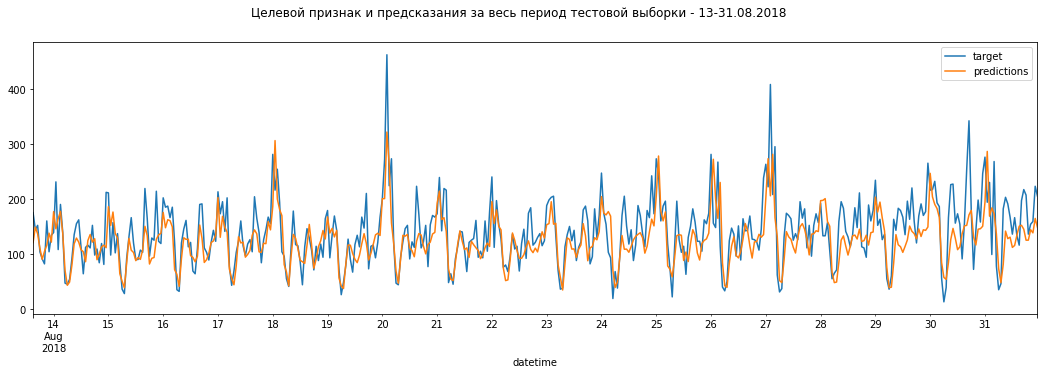

In [33]:
plt.figure(figsize=(18,5))
plt.suptitle('Целевой признак и предсказания за весь период тестовой выборки - 13-31.08.2018')
target_test.plot(label = 'target', legend = True) 
pd.Series(predictions, index=target_test.index).plot(label = 'predictions', legend = True);

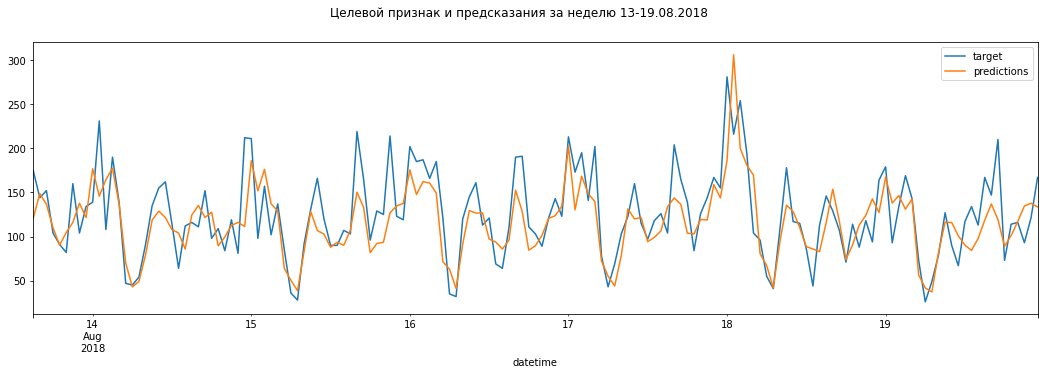

In [34]:
plt.figure(figsize=(18,5))
plt.suptitle('Целевой признак и предсказания за неделю 13-19.08.2018')
target_test['2018-08-13':'2018-08-19'].plot(label = 'target', legend = True) 
pd.Series(predictions, index=target_test.index)['2018-08-13':'2018-08-19'].plot(label = 'predictions', legend = True);

**Вывод**

RMSE на тестовой выборке 42.756.

Т.к. с марта по август количество перелетов возрастает в связи с наступлением лета и массовых отпусков, то дополнив датасет данными прошлого лета/года и обучав на них модель, мы могли бы получить более точные предсказания.